In [1]:
from utils import Model
import random
import numpy as np
import os
# Configuration (alphabetically)
import tensorflow as tf
tf.app.flags.DEFINE_integer('batch_size', 16,
                            "Number of samples per batch.")

tf.app.flags.DEFINE_string('checkpoint_dir', 'checkpoint',
                           "Output folder where checkpoints are dumped.")

tf.app.flags.DEFINE_integer('checkpoint_period', 10000,
                            "Number of batches in between checkpoints")

tf.app.flags.DEFINE_string('dataset', 'dataset',
                           "Path to the dataset directory.")

tf.app.flags.DEFINE_float('epsilon', 1e-8,
                          "Fuzz term to avoid numerical instability")

tf.app.flags.DEFINE_string('run', 'demo',
                            "Which operation to run. [demo|train]")

tf.app.flags.DEFINE_float('gene_l1_factor', .90,
                          "Multiplier for generator L1 loss term")

tf.app.flags.DEFINE_float('learning_beta1', 0.5,
                          "Beta1 parameter used for AdamOptimizer")

tf.app.flags.DEFINE_float('learning_rate_start', 0.00020,
                          "Starting learning rate used for AdamOptimizer")

tf.app.flags.DEFINE_integer('learning_rate_half_life', 5000,
                            "Number of batches until learning rate is halved")

tf.app.flags.DEFINE_bool('log_device_placement', False,
                         "Log the device where variables are placed.")

tf.app.flags.DEFINE_integer('sample_size', 64,
                            "Image sample size in pixels. Range [64,128]")

tf.app.flags.DEFINE_integer('summary_period', 200,
                            "Number of batches between summary data dumps")


tf.app.flags.DEFINE_integer('random_seed', 0,
                            "Seed used to initialize rng.")

tf.app.flags.DEFINE_integer('test_vectors', 16,
                            """Number of features to use for testing""")
                            
tf.app.flags.DEFINE_string('train_dir', 'train',
                           "Output folder where training logs are dumped.")

tf.app.flags.DEFINE_integer('train_time', 20,
                            "Time in minutes to train the model")

FLAGS = tf.app.flags.FLAGS

/home/egor/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [11]:
import tensorflow as tf


def setup_tensorflow():
    # Create session
    config = tf.ConfigProto(log_device_placement=FLAGS.log_device_placement)
    sess = tf.Session(config=config)

    # Initialize rng with a deterministic seed
    with sess.graph.as_default():
        tf.set_random_seed(FLAGS.random_seed)

    random.seed(FLAGS.random_seed)
    np.random.seed(FLAGS.random_seed)

    summary_writer = tf.summary.FileWriter(FLAGS.train_dir, sess.graph)

    return sess, summary_writer


def setup_inputs(sess, filenames, image_size=None, capacity_factor=3):
    if image_size is None:
        image_size = FLAGS.sample_size

    # Read each JPEG file
    reader = tf.WholeFileReader()
    filename_queue = tf.train.string_input_producer(filenames)
    key, value = reader.read(filename_queue)
    channels = 3
    image = tf.image.decode_jpeg(value, channels=channels, name="dataset_image")
    image.set_shape([64, 64, channels])

    # Crop and other random augmentations
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_saturation(image, .95, 1.05)
    image = tf.image.random_brightness(image, .05)
    image = tf.image.random_contrast(image, .95, 1.05)
    image = tf.reshape(image, [1, 64, 64, 3])
    image = tf.cast(image, tf.float32) / 255.0

    K = 2  # upscaling factor
    downsampled = tf.image.resize_area(image, [image_size / K, image_size / K])

    feature = tf.reshape(downsampled, [image_size / K, image_size / K, 3])
    label = tf.reshape(image, [image_size, image_size, 3])

    # Using asynchronous queues
    features, labels = tf.train.batch([feature, label],
                                      batch_size=FLAGS.batch_size * 8,
                                      num_threads=4,
                                      capacity=capacity_factor * FLAGS.batch_size,
                                      name='labels_and_features')

    tf.train.start_queue_runners(sess=sess)

    return features, labels

In [4]:
tf.reset_default_graph()
sess, summary_writer = setup_tensorflow()

In [5]:
def generator(features, params=None, return_params=False):
    # Upside-down all-convolutional resnet
    
    mapsize = 3

    # See Arxiv 1603.05027
    scope = 'g'
    model = Model(scope, features, params, '_0000_0000')
    
    for j in range(2):
        model.add_residual_block(256, mapsize=mapsize)

    # Spatial upscale (see http://distill.pub/2016/deconv-checkerboard/)
    # and transposed convolution
    # don't apply second upscaling (we need 2x factor)
    model.add_pixel_shuffler(2)#add_upscale()
    model.add_batch_norm()
    model.add_relu()
    gene_vars = model.params
    return model.get_output(), gene_vars
    #model.add_conv2d_transpose(256, mapsize=mapsize, stride=1, stddev_factor=1.)
       
    # Finalization a la "all convolutional net"
    
    model.add_conv2d(96, mapsize=mapsize, stride=1, stddev_factor=2.)
    # Worse: model.add_batch_norm()
    #model.add_relu()

    model.add_conv2d(96, mapsize=1, stride=1, stddev_factor=2.)
    # Worse: model.add_batch_norm()
    model.add_relu()

    # Last layer is sigmoid with no batch normalization
    model.add_conv2d(3, mapsize=1, stride=1, stddev_factor=1.)
    model.add_sigmoid() # TODO: add tanh
    
    gene_vars = model.params
    #model.summary()
    if return_params:
        return model.get_output(), gene_vars
    return model.get_output()

In [6]:
def discriminator(disc_input, params=None, return_params=False):
    # Fully convolutional model
    mapsize = 3
    layers = [64, 128, 256, 512]

    model = Model('d', 2 * disc_input - 1, params, mask='_0000_0000')  # normalize between -1 and 1

    for layer in range(len(layers)):
        nunits = layers[layer]
        stddev_factor = 2.0

        model.add_conv2d(nunits, mapsize=mapsize, stride=2, stddev_factor=stddev_factor)
        model.add_batch_norm()
        model.add_relu()

    # Finalization a la "all convolutional net"
    model.add_conv2d(nunits, mapsize=mapsize, stride=1, stddev_factor=stddev_factor)
    model.add_batch_norm()
    model.add_relu()

    model.add_conv2d(nunits, mapsize=1, stride=1, stddev_factor=stddev_factor)
    model.add_batch_norm()
    model.add_relu()

    # Linearly map to real/fake and return average score
    # (softmax will be applied later)
    model.add_conv2d(1, mapsize=1, stride=1, stddev_factor=stddev_factor)
    model.add_mean()

    disc_vars = model.params
    #model.summary()
    if return_params:
        return model.get_output(), disc_vars
    return model.get_output()

In [46]:
filenames = map(lambda x: os.path.join(FLAGS.dataset, x), os.listdir(FLAGS.dataset))
features, labels = setup_inputs(sess, filenames)
features, labels = tf.reshape(features, [FLAGS.batch_size, 8, 32, 32, 3]), tf.reshape(labels, [FLAGS.batch_size, 8, 64, 64, 3])
features = tf.transpose(features, [0, 2, 3, 4, 1])
labels = tf.transpose(labels, [0, 2, 3, 4, 1])

In [47]:
f, l =  sess.run([features, labels])

In [48]:
f.shape

(16, 32, 32, 3, 8)

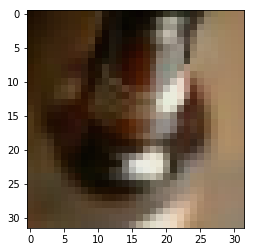

In [53]:
plt.imshow(f[12, :, :, :, 4])

In [9]:
l = sess.run(labels)

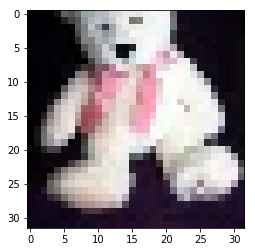

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(f[0])

In [8]:
# check whether gpu is alive
import tensorflow as tf
tf.reset_default_graph()
sess = tf.InteractiveSession()
with tf.device('gpu:0'):
    a = tf.constant(1, tf.float32, [100, 100])
    b = tf.constant(0.5, tf.float32, [100, 10])
    c = tf.matmul(a, b)
sess.run(c)

Exception in thread QueueRunnerThread-labels_and_features/fifo_queue-labels_and_features/fifo_queue_enqueue:
Traceback (most recent call last):
  File "/home/egor/anaconda2/lib/python2.7/threading.py", line 801, in __bootstrap_inner
    self.run()
  File "/home/egor/anaconda2/lib/python2.7/threading.py", line 754, in run
    self.__target(*self.__args, **self.__kwargs)
  File "/home/egor/anaconda2/lib/python2.7/site-packages/tensorflow/python/training/queue_runner_impl.py", line 238, in _run
    enqueue_callable()
  File "/home/egor/anaconda2/lib/python2.7/site-packages/tensorflow/python/client/session.py", line 1231, in _single_operation_run
    target_list_as_strings, status, None)
  File "/home/egor/anaconda2/lib/python2.7/site-packages/tensorflow/python/framework/errors_impl.py", line 473, in __exit__
    c_api.TF_GetCode(self.status.status))
NotFoundError: n04399382_279.JPEG; No such file or directory
	 [[Node: ReaderReadV2 = ReaderReadV2[_device="/job:localhost/replica:0/task:0/d

InvalidArgumentError: Cannot assign a device for operation 'MatMul': Operation was explicitly assigned to /device:GPU:0 but available devices are [ /job:localhost/replica:0/task:0/device:CPU:0 ]. Make sure the device specification refers to a valid device.
	 [[Node: MatMul = MatMul[T=DT_FLOAT, transpose_a=false, transpose_b=false, _device="/device:GPU:0"](Const, Const_1)]]

Caused by op u'MatMul', defined at:
  File "/home/egor/anaconda2/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/egor/anaconda2/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/egor/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/egor/anaconda2/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/egor/anaconda2/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/home/egor/anaconda2/lib/python2.7/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/egor/anaconda2/lib/python2.7/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/egor/anaconda2/lib/python2.7/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/egor/anaconda2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/egor/anaconda2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/egor/anaconda2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/egor/anaconda2/lib/python2.7/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/egor/anaconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/egor/anaconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/egor/anaconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/egor/anaconda2/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/egor/anaconda2/lib/python2.7/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/egor/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2718, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/egor/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2822, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/egor/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-d3bde120e163>", line 8, in <module>
    c = tf.matmul(a, b)
  File "/home/egor/anaconda2/lib/python2.7/site-packages/tensorflow/python/ops/math_ops.py", line 1891, in matmul
    a, b, transpose_a=transpose_a, transpose_b=transpose_b, name=name)
  File "/home/egor/anaconda2/lib/python2.7/site-packages/tensorflow/python/ops/gen_math_ops.py", line 2437, in _mat_mul
    name=name)
  File "/home/egor/anaconda2/lib/python2.7/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/egor/anaconda2/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 2956, in create_op
    op_def=op_def)
  File "/home/egor/anaconda2/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): Cannot assign a device for operation 'MatMul': Operation was explicitly assigned to /device:GPU:0 but available devices are [ /job:localhost/replica:0/task:0/device:CPU:0 ]. Make sure the device specification refers to a valid device.
	 [[Node: MatMul = MatMul[T=DT_FLOAT, transpose_a=false, transpose_b=false, _device="/device:GPU:0"](Const, Const_1)]]


In [7]:
gen_out, pars = generator(tf.constant(0.0, shape=features.shape, dtype=tf.float32), return_params=True)

In [8]:
sess.run(tf.global_variables_initializer())
a = sess.run(gen_out)

In [9]:
a.shape

(16, 64, 64, 64)

In [11]:
%%time
from arch import BSRGAN
tf.reset_default_graph()
bsrgan = BSRGAN(labels, features, 100000, J=2, J_d=2, M=2, batch_size=FLAGS.batch_size)

In [9]:
tf.trainable_variables()

[<tf.Variable 'g_h0_0000_0000/weight:0' shape=(1, 1, 3, 256) dtype=float32_ref>,
 <tf.Variable 'g_h0_0000_0000/bias:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'g_h1_0000_0000/batch_normalization/beta:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'g_h1_0000_0000/weight:0' shape=(3, 3, 256, 256) dtype=float32_ref>,
 <tf.Variable 'g_h1_0000_0000/bias:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'g_h2_0000_0000/batch_normalization/beta:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'g_h2_0000_0000/weight:0' shape=(3, 3, 256, 256) dtype=float32_ref>,
 <tf.Variable 'g_h2_0000_0000/bias:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'g_h3_0000_0000/batch_normalization/beta:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'g_h3_0000_0000/weight:0' shape=(3, 3, 256, 256) dtype=float32_ref>,
 <tf.Variable 'g_h3_0000_0000/bias:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'g_h4_0000_0000/batch_normalization/beta:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'g_h4_00

In [1]:
from utils import *

/home/egor/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
